# Estimation du Prix d'un Bien Immobilier 

# Alseny
### Data Scientist / Machine Learning Engineer

### Pipeline complet de data science appliqué à ce projet

🔷 1- Introduction.

🔷 2- Compréhension du besoin.

🔷 3- Récupération des données. 

🔷 4- Exploration (exploratory data analysis - EDA).

🔷 5- Nettoyage.

🔷 6- Data visualisation.

🔷 7-Encodage des variables catégorielles.

🔷 8- Sauvegarde des données prétraitées pour la phase de modélisation.

🔷 9- Modélisation.

🔷 10- Mise en place d’une application web interactive avec Streamlit pour l’exploration et la prédiction des prix       immobiliers à partir des données DVF.

#  🔷 9- Modélisation
- Importation des données nettoyées
- Initialisation des modèles
- Procédure d'évaluation
- Choix du modèle final
- Affichage des variables importantes
- Explicabilité du modèle (SHAP)
- Analyse des résultats
- Enregistrement du modèle au format .pkl pour une application web Streamlit

## Importation des packages

In [1]:
# Ramassage des objets inutiles en mémoire
import gc
gc.collect()

0

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import Utils  # Importation des fonctions définies dans le fichier utils.ipynb

Le notebook /home/sacko/Documents/ProjetDvfVersion1/Scripts/Utils.ipynb a été converti en script Python.


## 9.1- Importation des données nettoyées

##  Chargement DataSet Train

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [4]:
# Chargement des données
df_train_cleaned = Utils.load_and_save_data(
    file_path='/home/sacko/Documents/ProjetDvfVersion1/Scripts/df_train_cleaned.csv',
#      sample=0.2,               # Charger 20 % des données
#      random_state=42,          # Pour reproductibilité de l'échantillonnage
     index_col=0               # Utiliser la première colonne comme index
)

print(df_train_cleaned.shape)
df_train_cleaned.info()

(2139495, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 2139495 entries, 1793421 to 2914311
Data columns (total 15 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Surface_terrain                              float64
 1   Surface_reelle_bati                          float64
 2   Nombre_pieces_principales                    float64
 3   annee_mutation                               int64  
 4   mois_mutation                                int64  
 5   Valeur_fonciere                              float64
 6   code_postal_encoded                          float64
 7   Nature_mutation_Adjudication                 int64  
 8   Nature_mutation_Echange                      int64  
 9   Nature_mutation_Expropriation                int64  
 10  Nature_mutation_Vente                        int64  
 11  Nature_mutation_Vente_etat_futur_achevement  int64  
 12  Nature_mutation_Vente_terrain_a_batir        int64  
 1

In [5]:
# Séparation des variables explicatives et de la variable cible dans les données d'entraînement
X_train =  df_train_cleaned.drop(["Valeur_fonciere"], axis = 1)

y_train = df_train_cleaned["Valeur_fonciere"]

## Chargement DataSet test

In [6]:
# Chargement des données
df_test_cleaned = Utils.load_and_save_data(
    file_path='/home/sacko/Documents/ProjetDvfVersion1/Donnees/df_test_cleaned.csv',
#      sample=0.2,               # Charger 20 % des données
#      random_state=42,          # Pour reproductibilité de l'échantillonnage
     index_col=0               # Utiliser la première colonne comme index
)

print(df_test_cleaned.shape)
df_test_cleaned.info()

(536973, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 536973 entries, 3515754 to 16941
Data columns (total 15 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Surface_terrain                              536973 non-null  float64
 1   Surface_reelle_bati                          536973 non-null  float64
 2   Nombre_pieces_principales                    536973 non-null  float64
 3   annee_mutation                               536973 non-null  int64  
 4   mois_mutation                                536973 non-null  int64  
 5   Valeur_fonciere                              536973 non-null  float64
 6   code_postal_encoded                          536973 non-null  float64
 7   Nature_mutation_Adjudication                 536973 non-null  int64  
 8   Nature_mutation_Echange                      536973 non-null  int64  
 9   Nature_mutation_Expropriation                5

In [7]:
# Séparation des variables explicatives et de la variable cible dans les données test
X_test =  df_test_cleaned.drop(["Valeur_fonciere"], axis = 1)

y_test = df_test_cleaned["Valeur_fonciere"]

## 9.2- Initialisation des modèles

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from joblib import Parallel, delayed

In [9]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(max_iter=100, random_state=42),
}

## 9.3- Procédure d'évaluation

In [10]:
# Entraînement et évaluation optimisés
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [11]:
# Parallélisation de l'évaluation des modèles
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_model)(model, X_train, X_test, y_train, y_test) 
        for model in models.values()
    )
    return dict(zip(models.keys(), results))

In [12]:
# Affichage final des résultats
results = evaluate_models(models, X_train, X_test, y_train, y_test)

print("Final Results Summary:\n")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("-" * 30)
    print("\n")

Final Results Summary:

Random Forest:
  MAE: 2667.6573
  RMSE: 13234.2886
  R2: 0.9802
------------------------------


XGBoost:
  MAE: 45024.7757
  RMSE: 59408.1866
  R2: 0.6008
------------------------------


Hist Gradient Boosting:
  MAE: 46122.4539
  RMSE: 60829.5836
  R2: 0.5814
------------------------------




## 9.4- Choix du modèle final

In [13]:
# Récupérer le modèle Random Forest (meilleur modèle)
best_rf = models["Random Forest"]
# Ignorer les FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
    
# Entraîner le modèle Random Forest avant d'obtenir les importances
best_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

## 9.5- Importantes des variables


Top 10 des variables les plus importantes pour Random Forest :
                      Feature  Importance
5         code_postal_encoded    0.436163
1         Surface_reelle_bati    0.274705
0             Surface_terrain    0.154658
4               mois_mutation    0.060934
2   Nombre_pieces_principales    0.036375
3              annee_mutation    0.021725
13          Type_local_Maison    0.006991
12     Type_local_Appartement    0.004362
9       Nature_mutation_Vente    0.002281
7     Nature_mutation_Echange    0.000873


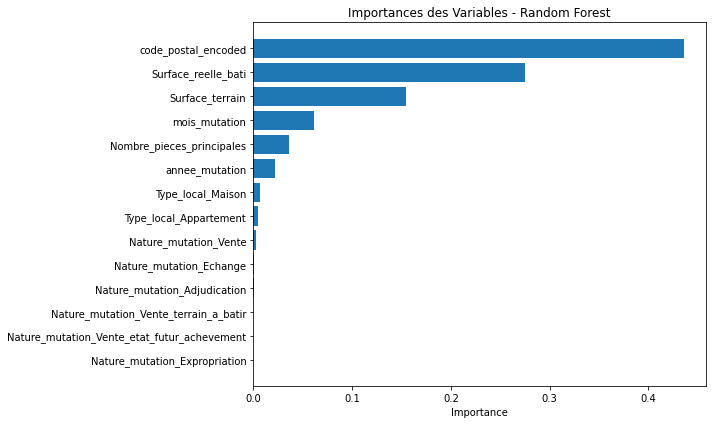

In [14]:
# Extraire les importances des variables
importances = best_rf.feature_importances_

# Créer un DataFrame pour mieux afficher
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Noms des variables
    'Importance': importances   # Importance associée
})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Affichage des top features
print("\nTop 10 des variables les plus importantes pour Random Forest :")
print(feature_importance_df.head(10))

# Affichage graphique
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Importances des Variables - Random Forest")
plt.gca().invert_yaxis()  # Pour afficher la plus importante en haut
plt.tight_layout()
plt.show()

## 9.5- Explicabilité du modèle

In [28]:
# Explicabilité
explainer = shap.Explainer(RandomForest)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

## 9.6- Analyse des Résultats :
### Métriques utilisées :
- MAE (Mean Absolute Error) : moyenne des erreurs absolues.

- RMSE (Root Mean Squared Error) : racine carrée de la moyenne des carrés des erreurs — pénalise davantage les 
  grandes erreurs.

- R² (coefficient de détermination) : mesure de la qualité de la prédiction (plus proche de 1 = meilleur).
### Random Forest :
-  MAE: 2667.6573

-  RMSE: 13234.2886

-  R2: 0.9802 

Meilleur modèle sur tous les indicateurs. Faible erreur, forte capacité explicative.
Indique une forte adéquation aux données.

### XGBoost :
-  MAE: 45024.7757

-  RMSE: 59408.1866

-  R2: 0.6008

Performances très inférieures à celles de la forêt aléatoire. Erreurs plus importantes et explication plus faible de la variance.

### Hist Gradient Boosting
-  MAE: 46122.4539

-  RMSE: 60829.5836

-  R2: 0.5814

Très similaire à XGBoost, mais légèrement pire.

## Conclusion :
- Le modèle Random Forest surperforme largement les deux autres avec une erreur moyenne très faible et un R² proche de 1. Cela indique une excellente capacité de prédiction.
- Les modèles XGBoost et HistGradientBoosting montrent des performances nettement inférieures, avec des erreurs plus importantes et un pouvoir explicatif limité.

## Enregistrement du modèle au format .pkl pour une application web Streamlit

In [59]:
# Sauvegarde pour Streamlit
import pickle
with open("App_DVF.pkl", "wb") as f:
    
    pickle.dump(best_rf, f)
    
print("✅ Modèle entraîné et sauvegardé sous 'Model_DVF.pkl'")

✅ Modèle entraîné et sauvegardé sous 'Model_DVF.pkl'
